In [1]:
# ALL THANKS AND GLORY TO THE AND my ONLY GOD AND LORD JESUS CHRIST ALONE

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy.stats import skew, kurtosis, entropy
from scipy.signal import get_window
from scipy.fft import rfft, rfftfreq


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter

from imblearn.over_sampling import SMOTE



In [69]:
# !python --version


In [70]:
# !pip install torch

In [71]:
# !pip install tensorflow
# !pip show tensorflow

In [72]:
# !conda info --envs

In [73]:
# !conda info

In [74]:
# !pip install sktime

Importing dataset

In [75]:
# !pip install tensorflow
# import tensorflow as tf

In [76]:
#!pip install tsai, requires an additional compiler for .blis programs/packages/dependies to be instaalled, may not be needed

In [77]:
# !pip install sktime

In [2]:
df = pd.read_csv("datasets/GTLJC_data3.csv")

In [33]:
import ahrs

The embedded system seats horizontally with one of its two length-wise edges facing the operator, hence correcting misidentifying axes...


In [3]:
#BY GOD'S GRACE ALONE
# Correcting the axes along which the sensor readings were taken
df["acc_x_corrected"] = -df["acc_y"]
df["acc_y_corrected"] = df["acc_x"]
df["acc_z_corrected"] = df["acc_z"]

df["rot_x_corrected"] = -df["rot_y"]
df["rot_y_corrected"] = df["rot_x"]
df["rot_z_corrected"] = df["rot_z"]

df.drop(columns=["acc_x","acc_y","acc_z","rot_x","rot_y","rot_z"],inplace=True)

Aligning original acceleration and rotation readings with the global frame / a vehicle's rectangular coordinates' system

In [4]:
import numpy as np
import pandas as pd
from ahrs.filters import Madgwick
from scipy.spatial.transform import Rotation as R

# Example: assume `df` has columns: ['acc_x_corrected',..., 'rot_x_corrected',...]
## Ensure original acceleration and rotation readings are pseudo-aligned with the global frame 

# === 2. Extract raw values ===
accel = df[['acc_x_corrected', 'acc_y_corrected', 'acc_z_corrected']].to_numpy()
gyro = df[['rot_x_corrected', 'rot_y_corrected', 'rot_z_corrected']].to_numpy()
sample_period = 1/40  # 40 Hz

# === 3. Estimate orientation using Madgwick filter ===
madgwick = Madgwick(sampleperiod=sample_period)
quaternions = np.zeros((len(df), 4))
q = np.array([1.0, 0.0, 0.0, 0.0])

for i in range(len(df)):
    q = madgwick.updateIMU(q, gyr=gyro[i], acc=accel[i])
    quaternions[i] = q

# === 4. Rotate sensor-frame acceleration into global frame ===
accel_global = np.zeros_like(accel)
for i in range(len(df)):
    q = quaternions[i]
    rotation = R.from_quat([q[1], q[2], q[3], q[0]])  # scipy expects [x, y, z, w]
    accel_global[i] = rotation.apply(accel[i])

# === 5. Combine into DataFrame and export ===
df_global = pd.DataFrame(accel_global, columns=['acc_x_global', 'acc_y_global', 'acc_z_global'])
df_combined = pd.concat([df, df_global], axis=1)

# Save to CSV
df_combined.to_csv("imu_with_global_accel.csv", index=False)
print("Saved processed IMU data with global acceleration as 'imu_with_global_accel.csv'")
df_combined.head()


Saved processed IMU data with global acceleration as 'imu_with_global_accel.csv'


,batch,speed,timestamp,latitude,longitude,accuracy,date_time,anomaly,speed_level,acc_x_corrected,acc_y_corrected,acc_z_corrected,rot_x_corrected,rot_y_corrected,rot_z_corrected,acc_x_global,acc_y_global,acc_z_global
0,5,2.767711,0,7.285094,5.223166,2.05,07/19/2025 14:39:12:-0.000000,smooth,AVERAGE,-0.99,2.34,8.00,0.07,0.19,0.38,-0.981602,2.325788,8.005178
1,5,2.767711,24,7.285094,5.223166,2.05,07/19/2025 14:39:12:-0.000000,smooth,AVERAGE,-1.40,3.70,8.70,0.16,0.27,0.40,-1.384364,3.658440,8.720055
2,5,2.767711,48,7.285094,5.223166,2.05,07/19/2025 14:39:12:-0.000000,smooth,AVERAGE,-0.67,3.94,11.17,-0.13,-0.03,0.46,-0.664055,3.899432,11.184581
3,5,2.767711,72,7.285094,5.223166,2.05,07/19/2025 14:39:12:-0.000000,smooth,AVERAGE,-0.45,2.28,8.29,-0.10,0.02,0.05,-0.436154,2.253232,8.298055
4,5,2.767711,96,7.285094,5.223166,2.05,07/19/2025 14:39:12:1.770893,smooth,AVERAGE,-1.29,1.85,9.50,-0.02,0.07,-0.02,-1.253627,1.806490,9.513234


Assigned to df the global-frame-aligned acceleration and rotational velocity data

In [5]:
df = df_combined
df.head()


,batch,speed,timestamp,latitude,longitude,accuracy,date_time,anomaly,speed_level,acc_x_corrected,acc_y_corrected,acc_z_corrected,rot_x_corrected,rot_y_corrected,rot_z_corrected,acc_x_global,acc_y_global,acc_z_global
0,5,2.767711,0,7.285094,5.223166,2.05,07/19/2025 14:39:12:-0.000000,smooth,AVERAGE,-0.99,2.34,8.00,0.07,0.19,0.38,-0.981602,2.325788,8.005178
1,5,2.767711,24,7.285094,5.223166,2.05,07/19/2025 14:39:12:-0.000000,smooth,AVERAGE,-1.40,3.70,8.70,0.16,0.27,0.40,-1.384364,3.658440,8.720055
2,5,2.767711,48,7.285094,5.223166,2.05,07/19/2025 14:39:12:-0.000000,smooth,AVERAGE,-0.67,3.94,11.17,-0.13,-0.03,0.46,-0.664055,3.899432,11.184581
3,5,2.767711,72,7.285094,5.223166,2.05,07/19/2025 14:39:12:-0.000000,smooth,AVERAGE,-0.45,2.28,8.29,-0.10,0.02,0.05,-0.436154,2.253232,8.298055
4,5,2.767711,96,7.285094,5.223166,2.05,07/19/2025 14:39:12:1.770893,smooth,AVERAGE,-1.29,1.85,9.50,-0.02,0.07,-0.02,-1.253627,1.806490,9.513234


In [6]:
# BY GOD'S GRACE ALONE
# Graciously  slicing data into unique anomaly  types
mask_no_movement = df["anomaly"] == "no-movement"
mask_static_vibration = df["anomaly"] == "static-vibration"
mask_smooth = df["anomaly"] == "smooth"
mask_crack = df["anomaly"] == "crack"
mask_bump = df["anomaly"] == "bump"
mask_road_patch = df["anomaly"] == "road-patch"
mask_pothole_mild = df["anomaly"] == "pothole_mild"
mask_pothole_severe = df["anomaly"] == "pothole_severe"


df_smooth = df[mask_smooth]
df_no_movement = df[mask_no_movement] 
df_static_vibration = df[mask_static_vibration]
df_smooth = df[mask_smooth]
df_crack = df[mask_crack]
df_bump = df[mask_bump]
df_road_patch = df[mask_road_patch]
df_pothole_mild = df[mask_pothole_mild]
df_pothole_severe = df[mask_pothole_severe]


Counting the number of unique(un-repeated) batches for each anomaly

In [7]:
# BY GOD'S GRACE ALONE
df_smooth["batch"].value_counts().count

<bound method Series.count of batch
0      220
25     200
23     200
1      200
2      200
      ... 
109    100
108    100
8      100
54      30
21       9
Name: count, Length: 86, dtype: int64>

In [8]:
df_no_movement["batch"].value_counts().count

<bound method Series.count of batch
2     100
3     100
32    100
33    100
34    100
35    100
36    100
37    100
38    100
39    100
40    100
42    100
43    100
44    100
45    100
46    100
47    100
48    100
49    100
50    100
51    100
52    100
53    100
54    100
55    100
31    100
30    100
29    100
28    100
4     100
5     100
9     100
10    100
11    100
12    100
13    100
14    100
15    100
16    100
17    100
18    100
21    100
22    100
23    100
24    100
27    100
56    100
26     83
41     77
19     61
25     45
20     43
6      27
Name: count, dtype: int64>

In [9]:
df_crack["batch"].value_counts().count

<bound method Series.count of batch
32     248
5      200
13     200
33     200
6      200
4      200
1      200
16     200
29     200
12     200
11     200
9      200
14     100
44     100
21     100
20     100
19     100
3      100
2      100
128    100
127    100
107    100
63     100
62     100
7      100
43     100
15     100
8      100
31     100
30     100
28     100
10     100
57     100
56     100
45     100
27     100
Name: count, dtype: int64>

In [10]:
# BY GOD'S GRACE ALONE
df_bump["batch"].value_counts().count

<bound method Series.count of batch
23    100
24    100
28    100
30    100
31    100
17     78
80     26
22     20
20     16
15      9
46      7
Name: count, dtype: int64>

Some batches like in the smooth-road-segment dataset, span more than a 100 samples, indicative of repeated batch assignment to different (possibly non consecutive) intervals of readings,  now below is a function to reorganize the batches of each anomaly type into a unique batches containing at most 100  continuous readings of the same type

In [11]:
#BY GOD'S GRACE ALONE
def fix_batches(df_anomaly_type,batch_col = 'batch', expected_size = 100, min_batch_size = 30):
    new_rows = [] # Graciously to be used to store all the fixed-size rows to be elicited
    
    #Graciously regrouping rows in df_anomaly_type by common batch ids
    for batch_id, group in df_anomaly_type.groupby(batch_col):
        group = group.reset_index(drop=True)
        anomaly = df_anomaly_type["anomaly"].iloc[0]

        #If group size <= expected size, keep as is
        if len(group) <= expected_size:
            group[batch_col] = f"{group[batch_col].iloc[0]}_{anomaly}"
            new_rows.append(group)
        else:
            #Graciously splitting the group into chunks of size
            for i in range(0,len(group),expected_size):
                chunk = group.iloc[i:i+expected_size].copy()
                #Graciously assigning a new unique batch name to new chunk
                
                chunk[batch_col] = f"{batch_id}_{i//expected_size}_{anomaly}"
                new_rows.append(chunk)
 
    # Graciously concantenating all chunks back together
    fixed_df = pd.concat(new_rows, ignore_index=True)

    newer_rows = []
    for batch_id, group in fixed_df.groupby(batch_col):
        if len(group) <= min_batch_size:
           continue
        newer_rows.append(group)

    fixed_df = pd.concat(newer_rows, ignore_index=True)
    return fixed_df


In [12]:
# BY GOD'S GRACE ALONE
# Usage of above routine

df_no_movement_reorganized = not df_no_movement.empty and fix_batches(df_no_movement, batch_col="batch", expected_size=100)
df_static_vibration_reorganized = not df_static_vibration.empty and fix_batches(df_static_vibration, batch_col="batch", expected_size=100)

df_smooth_reorganized = not df_smooth.empty and fix_batches(df_smooth, batch_col="batch", expected_size=100)
df_crack_reorganized = not df_crack.empty and fix_batches(df_crack, batch_col="batch", expected_size=100)

df_bump_reorganized = not df_bump.empty and  fix_batches(df_bump, batch_col="batch", expected_size=100)
df_road_patch_reorganized = not df_road_patch.empty and fix_batches(df_road_patch, batch_col="batch", expected_size=100)

df_pothole_mild_reorganized = not df_pothole_mild.empty and fix_batches(df_pothole_mild, batch_col="batch", expected_size=100)
df_pothole_severe_reorganized = not df_pothole_severe.empty and fix_batches(df_pothole_severe, batch_col="batch", expected_size=100)


In [13]:
df_smooth_reorganized["batch"].value_counts()

batch
0_0_smooth     100
25_1_smooth    100
24_1_smooth    100
24_0_smooth    100
23_1_smooth    100
              ... 
159_smooth     100
158_smooth     100
157_smooth     100
8_smooth       100
3_1_smooth      48
Name: count, Length: 92, dtype: int64

In [14]:
df_bump_reorganized["batch"].value_counts()

batch
23_bump    100
24_bump    100
28_bump    100
30_bump    100
31_bump    100
17_bump     78
Name: count, dtype: int64

In [15]:
df_pothole_severe_reorganized["batch"].value_counts()

batch
100_pothole_severe     100
54_pothole_severe      100
62_pothole_severe      100
61_1_pothole_severe    100
61_0_pothole_severe    100
                      ... 
14_pothole_severe      100
12_pothole_severe       87
76_pothole_severe       79
71_pothole_severe       56
64_pothole_severe       48
Name: count, Length: 130, dtype: int64

In [16]:
# BY GOD'S GRACE ALONE
df_smooth_reorganized["batch"].value_counts()

batch
0_0_smooth     100
25_1_smooth    100
24_1_smooth    100
24_0_smooth    100
23_1_smooth    100
              ... 
159_smooth     100
158_smooth     100
157_smooth     100
8_smooth       100
3_1_smooth      48
Name: count, Length: 92, dtype: int64

Engineering data to derive time- and frequency-domain features that are hopefully characteristic of anomaly type

In [17]:
df_smooth_reorganized.columns

Index(['batch', 'speed', 'timestamp', 'latitude', 'longitude', 'accuracy',
       'date_time', 'anomaly', 'speed_level', 'acc_x_corrected',
       'acc_y_corrected', 'acc_z_corrected', 'rot_x_corrected',
       'rot_y_corrected', 'rot_z_corrected', 'acc_x_global', 'acc_y_global',
       'acc_z_global'],
      dtype='object')

In [18]:
batch_smooth = "0_0_smooth"
mask_batch_smooth = df_smooth_reorganized["batch"] == batch_smooth
df_smooth_reorganized_batch_smooth = df_smooth_reorganized[mask_batch_smooth]

Text(0.5, 1.0, 'Smooth Road')

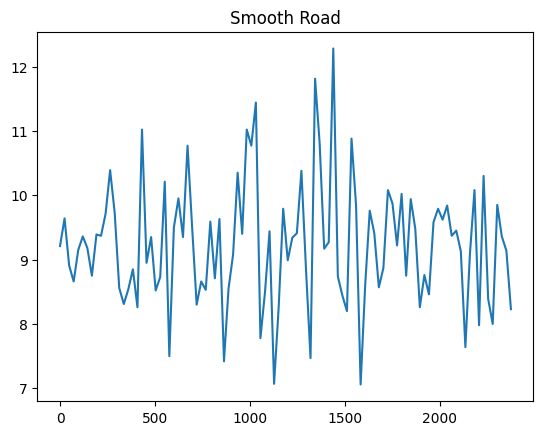

In [19]:
plt.plot(df_smooth_reorganized_batch_smooth["timestamp"], df_smooth_reorganized_batch_smooth["acc_z_corrected"]);
plt.title("Smooth Road")

In [20]:
plt.plot(df_pothole_severe_reorganized_batch_bump["timestamp"], df_pothole_severe_reorganized_batch_bump["acc_z_corrected"]);
plt.xlabel("")
plt.title("Potholes")

NameError: name 'df_pothole_severe_reorganized_batch_bump' is not defined

In [21]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis, entropy
from scipy.signal import butter, filtfilt, welch
from scipy.fft import fft


def apply_filter(data, fs, cutoff, filter_type='lowpass', order=4):
    """
    Apply an IIR filter (Butterworth) to the input signal.
    """
    nyq = 0.5 * fs
    if filter_type in ['lowpass', 'highpass']:
        norm_cutoff = cutoff / nyq
    elif filter_type in ['bandpass', 'bandstop']:
        norm_cutoff = [c / nyq for c in cutoff]
    else:
        raise ValueError("Invalid filter_type. Choose from 'lowpass', 'highpass', 'bandpass', 'bandstop'.")

    b, a = butter(order, norm_cutoff, btype=filter_type)
    return filtfilt(b, a, data)


def extract_fft_features(signal, fs):
    N = len(signal)
    freq = np.fft.fftfreq(N, d=1/fs)
    spectrum = np.abs(fft(signal))[:N//2]
    freqs = freq[:N//2]

    # Power spectrum
    power = spectrum ** 2
    power_norm = power / np.sum(power) if np.sum(power) != 0 else power

    dom_freq = freqs[np.argmax(power)]
    spec_entropy = entropy(power_norm)
    spec_centroid = np.sum(freqs * power_norm)

    # Band power in bins (e.g. 0–5 Hz, 5–10 Hz, ..., up to Nyquist)
    bands = [(i, i + 5) for i in range(0, int(fs // 2), 5)]
    band_powers = [np.sum(power[(freqs >= low) & (freqs < high)]) for low, high in bands]

    # Energy in specific bands
    energy = np.sum(power)
    spec_skew = skew(power)
    spec_kurt = kurtosis(power)

    return {
        "dominant_frequency": dom_freq,
        "spectral_entropy": spec_entropy,
        "spectral_centroid": spec_centroid,
        **{f"band_power_{i}-{j}Hz": p for (i, j), p in zip(bands, band_powers)},
        "spectral_energy": energy,
        "spectral_skewness": spec_skew,
        "spectral_kurtosis": spec_kurt,
    }


def extract_features_windowed(df, fs, window_size, stride, filter_cfg=None):
    features = []
    signal_columns = ['acc_x_global', 'acc_y_global', 'acc_z_global', 'rot_x_corrected', 'rot_y_corrected', 'rot_z_corrected']
    labels = []
    batch_list = []
    start_idxs = np.arange(0, len(df) - window_size + 1, stride)

    for start in start_idxs:
        window = df.iloc[start:start + window_size]
        label = window['anomaly'].mode()[0]
        batch = window["batch"].mode()[0]

        feature_vector = {}

        for col in signal_columns:
            signal = window[col].values

            if filter_cfg:
                signal = apply_filter(
                    signal,
                    fs=fs,
                    cutoff=filter_cfg.get('cutoff', 10),
                    filter_type=filter_cfg.get('type', 'lowpass'),
                    order=filter_cfg.get('order', 4)
                )

            # Time-domain features
            feature_vector[f"{col}_mean"] = np.mean(signal)
            feature_vector[f"{col}_std"] = np.std(signal)
            feature_vector[f"{col}_min"] = np.min(signal)
            feature_vector[f"{col}_max"] = np.max(signal)
            feature_vector[f"{col}_rms"] = np.sqrt(np.mean(signal**2))
            feature_vector[f"{col}_range"] = np.ptp(signal)

            # Frequency-domain features
            fft_feats = extract_fft_features(signal, fs)
            for k, v in fft_feats.items():
                feature_vector[f"{col}_{k}"] = v

        features.append(feature_vector)
        labels.append(label)
        batch_list.append(batch)

        features_df = pd.DataFrame(features)
        features_df["label"] = labels
        features_df["batch"] = batch_list

    return features_df


# BY GOD'S GRACE ALONE,
Graciously Recall: Higher sampling rate (even above the no of samples),  results in finer sampling, but may cause unintended interpolations not present in original data, begin confidently at the samplng_rate_per_batch equals len/no of samples

### Extracting features using sliding windows

In [23]:


def apply_feature_extraction_across_all_identical_anomaly_batches(entire_df,window_size = 20,window_stride = 5, cutoff_freq = 20):
    combined_df = pd.DataFrame()

    for batch_id, group in entire_df.groupby("batch"):
        signal_length = len(group)
        fs = signal_length
        filter_cfg = {
            "cutoff" : min(cutoff_freq, len(group)),                  # Cutoff frequency of 20 Hz
            "type"   : "lowpass",
            "order"  : 4
        }
        window_size = window_size
        stride = window_stride

        if signal_length < 2:
            print("Graciously skipping too short batches")
            continue # Graciously skipping too short batches
            

        # Dynamically constraining window size and stride, so that sample-length of signal is not exceeded
        dynamic_window = min(window_size, signal_length )
        dynamic_stride = min(stride, dynamic_window)

        if signal_length < dynamic_window:
            print("Not enough data to form a window")
            continue # Not enough data to form a window

        num_windows = 1 + (signal_length - dynamic_window) // dynamic_stride

        if num_windows <= 0:
            print("Zero or negative strides are disregarded")
            continue # Zero or negative strides are disregarded

         # Extract features for current batch
        features_df = extract_features_windowed(group, fs, window_size, stride, filter_cfg = filter_cfg)
        combined_df = pd.concat([combined_df, features_df], ignore_index=True)

    return combined_df

# Note, moderately wide windows (15 - 30 samples) [for a signal sampled at 100 Hz] and small window strides (3 - 7 samples) could give comprehensive frequency-domain extraction of features

 Choosing window-width to equal 20 samples and window_stride to be 5 samples per stride/step
 Also note that the window_width is preconstrained to a fixed minimum of 16 samples

In [24]:
# BY GOD'S GRACE 

df_smooth_engineered= apply_feature_extraction_across_all_identical_anomaly_batches(df_smooth_reorganized, window_size=20, window_stride=2, cutoff_freq=20)
df_smooth_engineered.head()

#To revisit the window stride and size arguments, and study how changes in their values impact the constraints around a signal's cutoff frequency

,acc_x_global_mean,acc_x_global_std,acc_x_global_min,acc_x_global_max,acc_x_global_rms,acc_x_global_range,acc_x_global_dominant_frequency,acc_x_global_spectral_entropy,acc_x_global_spectral_centroid,acc_x_global_band_power_0-5Hz,...,rot_z_corrected_band_power_25-30Hz,rot_z_corrected_band_power_30-35Hz,rot_z_corrected_band_power_35-40Hz,rot_z_corrected_band_power_40-45Hz,rot_z_corrected_band_power_45-50Hz,rot_z_corrected_spectral_energy,rot_z_corrected_spectral_skewness,rot_z_corrected_spectral_kurtosis,label,batch
0,-0.028692,0.256624,-0.437011,0.432693,0.258223,0.869704,5.0,0.763406,6.699281,0.329301,...,0.000699,0.000524,0.000433,0.000379,0.000351,0.039504,1.710180,1.357887,smooth,0_0_smooth
1,0.049012,0.303672,-0.556544,0.444630,0.307602,1.001173,5.0,1.362680,8.772325,0.960855,...,0.000017,0.000007,0.000005,0.000004,0.000004,0.023969,1.786532,1.585934,smooth,0_0_smooth
2,0.082334,0.277458,-0.369582,0.465401,0.289417,0.834984,5.0,1.332036,7.219004,2.711535,...,0.000393,0.000295,0.000244,0.000213,0.000198,0.034224,1.901446,2.328585,smooth,0_0_smooth
3,0.168954,0.268742,-0.370353,0.651199,0.317440,1.021552,0.0,1.641125,8.386317,11.418239,...,0.001175,0.000845,0.000680,0.000592,0.000547,0.047648,1.562089,0.616955,smooth,0_0_smooth
4,0.250492,0.208161,-0.167906,0.575707,0.325695,0.743612,0.0,0.911323,3.388879,25.098520,...,0.000450,0.000305,0.000260,0.000231,0.000216,0.078736,1.865662,1.939304,smooth,0_0_smooth


In [25]:
df_smooth_engineered["batch"].value_counts()

batch
0_0_smooth     41
25_1_smooth    41
24_1_smooth    41
24_0_smooth    41
23_1_smooth    41
               ..
159_smooth     41
158_smooth     41
157_smooth     41
8_smooth       41
3_1_smooth     15
Name: count, Length: 92, dtype: int64

# Obtaining the feature-engineered versions of reorganized anomaly datasets

Graciously note that in the above,  there are multiple instances of identical batches in the feature-processed data, this is a consequence of the windowing and overlapping operations, which capture N intervals of samples in a batch and accordingly produce N equal-label-differently-windowed sub-batches belonging to the same batch. In other words it is safe to have multiple rows of engineered-features belonging to different sub-batches in the same batch 

### Also note that the filter's cutoff frequency cannot be higher than the sampling frequency (no of samples in each unique batch)

In [36]:
df_crack_engineered             =   apply_feature_extraction_across_all_identical_anomaly_batches(df_crack_reorganized,window_size=20, window_stride=5, cutoff_freq=20)

df_bump_engineered              =   apply_feature_extraction_across_all_identical_anomaly_batches(df_bump_reorganized, window_size=20, window_stride=5, cutoff_freq=20)
df_road_patch_engineered        =   apply_feature_extraction_across_all_identical_anomaly_batches(df_road_patch_reorganized, window_size=20, window_stride=5)

df_pothole_mild_engineered      =   apply_feature_extraction_across_all_identical_anomaly_batches(df_pothole_mild_reorganized, window_size=20, window_stride=5)
df_pothole_severe_engineered    =   apply_feature_extraction_across_all_identical_anomaly_batches(df_pothole_severe_reorganized, window_size=20, window_stride=5)

df_no_movement_engineered       =   apply_feature_extraction_across_all_identical_anomaly_batches(df_no_movement_reorganized, window_size=20, window_stride=5)
df_static_vibration_engineered  =   apply_feature_extraction_across_all_identical_anomaly_batches(df_static_vibration_reorganized, window_size=20, window_stride=5)


df_combined_engineered = pd.concat([
    df_no_movement_engineered,
    df_static_vibration_engineered,
    df_smooth_engineered,
    df_crack_engineered,
    df_bump_engineered,
    df_road_patch_engineered,
    df_pothole_mild_engineered,
    df_pothole_severe_engineered,
], ignore_index=True)

In [37]:
# BY GOD'S GRACE ALONE
df_combined_engineered.shape

(8082, 134)

In [55]:
# BY GOD'S GRACE ALONE
df_combined_engineered.head()

,acc_x_global_mean,acc_x_global_std,acc_x_global_min,acc_x_global_max,acc_x_global_rms,acc_x_global_range,acc_x_global_dominant_frequency,acc_x_global_spectral_entropy,acc_x_global_spectral_centroid,acc_x_global_band_power_0-5Hz,...,rot_z_corrected_band_power_25-30Hz,rot_z_corrected_band_power_30-35Hz,rot_z_corrected_band_power_35-40Hz,rot_z_corrected_band_power_40-45Hz,rot_z_corrected_band_power_45-50Hz,rot_z_corrected_spectral_energy,rot_z_corrected_spectral_skewness,rot_z_corrected_spectral_kurtosis,label,batch
0,-1.305420,0.097939,-1.461452,-1.151409,1.309089,0.310043,0.0,0.021458,0.037466,681.648436,...,0.001882,0.001451,0.001176,0.001027,9.503502e-04,0.063134,2.123003,3.034392,no-movement,10_no-movement
1,-1.274738,0.083589,-1.455829,-1.150601,1.277475,0.305228,0.0,0.017757,0.030987,649.982353,...,0.000203,0.000085,0.000048,0.000030,2.278092e-05,0.041904,1.468717,0.959130,no-movement,10_no-movement
2,-1.267005,0.054703,-1.378814,-1.150480,1.268185,0.228334,0.0,0.008756,0.015271,642.120762,...,0.000012,0.000018,0.000018,0.000017,1.641290e-05,0.025269,1.357047,0.403926,no-movement,10_no-movement
3,-1.261191,0.062337,-1.400015,-1.122926,1.262731,0.277089,0.0,0.011309,0.021012,636.241596,...,0.000019,0.000005,0.000002,0.000001,7.074395e-07,0.006850,1.674427,1.653390,no-movement,10_no-movement
4,-1.232955,0.048624,-1.308605,-1.161241,1.233913,0.147363,0.0,0.006976,0.005860,608.071063,...,0.000696,0.000349,0.000257,0.000214,1.937637e-04,0.008728,0.803115,-1.199289,no-movement,10_no-movement


In [38]:
# BY GOD'S GRACE ALONE
df_combined_engineered["label"].value_counts().count

<bound method Series.count of label
smooth              3746
pothole_severe      2182
no-movement          844
crack                822
road-patch           238
static-vibration     119
bump                  97
pothole_mild          34
Name: count, dtype: int64>

In [39]:
# BY GOD'S GRACE ALONE

df_combined_engineered.dropna(inplace=True)
df_combined_engineered.shape


(7964, 134)

In [40]:
# BY GOD'S GRACE ALONE
df_combined_engineered["label"].value_counts().count

<bound method Series.count of label
smooth              3731
pothole_severe      2142
crack                816
no-movement          799
road-patch           238
static-vibration     119
bump                  85
pothole_mild          34
Name: count, dtype: int64>

In [41]:
df_combined_engineered.select_dtypes("object").columns

Index(['label', 'batch'], dtype='object')

In [42]:
#BY GOD'S GRACE ALONE
# Graciously splitting the full engineered dataset
X = df_combined_engineered.drop(columns=["label","batch"])
y= df_combined_engineered["label"]

X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,random_state=42)

In [56]:
# BY GOD'S GRACE ALONE
X_train.head()

,acc_x_global_mean,acc_x_global_std,acc_x_global_min,acc_x_global_max,acc_x_global_rms,acc_x_global_range,acc_x_global_dominant_frequency,acc_x_global_spectral_entropy,acc_x_global_spectral_centroid,acc_x_global_band_power_0-5Hz,...,rot_z_corrected_band_power_15-20Hz,rot_z_corrected_band_power_20-25Hz,rot_z_corrected_band_power_25-30Hz,rot_z_corrected_band_power_30-35Hz,rot_z_corrected_band_power_35-40Hz,rot_z_corrected_band_power_40-45Hz,rot_z_corrected_band_power_45-50Hz,rot_z_corrected_spectral_energy,rot_z_corrected_spectral_skewness,rot_z_corrected_spectral_kurtosis
7810,1.430987,0.370563,0.795249,2.000030,1.478188,1.204782,0.0,0.177362,0.337064,819.089566,...,0.000710,0.001030,0.000068,0.000022,0.000010,0.000005,2.912694e-06,0.069481,2.583519,4.829167
1136,0.031242,0.379939,-1.403312,0.422564,0.381221,1.825876,20.0,1.897002,17.065188,0.390434,...,0.001906,0.000539,0.000526,0.000299,0.000249,0.000219,2.023719e-04,0.065587,2.656157,5.077796
7827,1.484462,0.429966,0.617710,2.311262,1.545477,1.693551,0.0,0.235471,0.515866,881.451043,...,0.002656,0.003337,0.001576,0.001026,0.000806,0.000693,6.358261e-04,0.149495,2.641363,5.029827
3318,1.309778,0.226362,0.899277,1.639104,1.329194,0.739827,0.0,0.084676,0.222143,686.207069,...,0.000446,0.001327,0.000063,0.000062,0.000046,0.000039,3.523720e-05,0.491827,2.666428,5.110367
4881,1.129542,0.211495,0.747675,1.428739,1.149172,0.681064,0.0,0.102195,0.143776,510.346421,...,0.000639,0.000352,0.000033,0.000014,0.000006,0.000002,4.676157e-07,0.025954,2.450067,4.361773


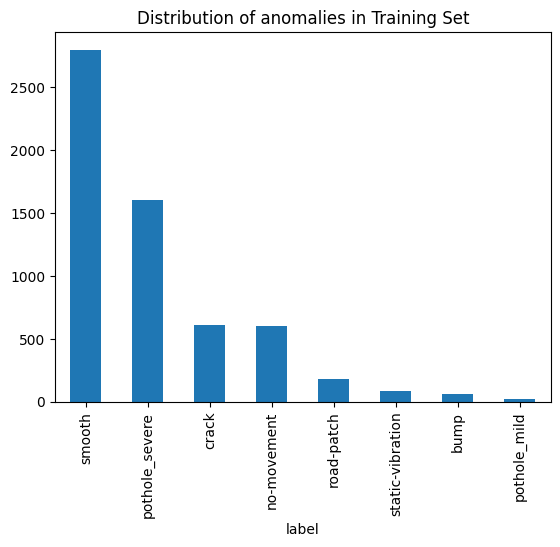

In [43]:
# Distributions of training and test sets
Counter(y_train)
y_train.value_counts().plot(kind = "bar")
plt.title("Distribution of anomalies in Training Set");

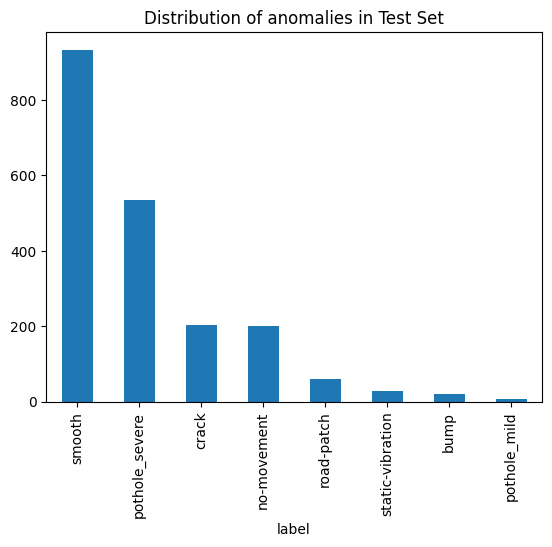

In [44]:
Counter(y_test)
y_test.value_counts().plot(kind = "bar")
plt.title("Distribution of anomalies in Test Set");

# BY GOD'S GRACE ALONE
## Model Building Process

In [45]:
model = RandomForestClassifier(n_estimators=500,random_state=42)
model.fit(X_train,y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))

                  precision    recall  f1-score   support

            bump       0.83      0.24      0.37        21
           crack       0.80      0.29      0.43       204
     no-movement       0.99      0.99      0.99       200
    pothole_mild       1.00      0.12      0.22         8
  pothole_severe       0.85      0.96      0.90       535
      road-patch       0.90      0.15      0.26        60
          smooth       0.86      0.98      0.92       933
static-vibration       1.00      0.77      0.87        30

        accuracy                           0.87      1991
       macro avg       0.90      0.56      0.62      1991
    weighted avg       0.87      0.87      0.84      1991



# GLORY TO GOD, A least average precision(correctness) and recall(closeness to reality) of 87% was achieved, to later move on to minimum performance-scores of 90%

In [47]:
# BY GOD'S GRACE ALONE
X_test.head()

,acc_x_global_mean,acc_x_global_std,acc_x_global_min,acc_x_global_max,acc_x_global_rms,acc_x_global_range,acc_x_global_dominant_frequency,acc_x_global_spectral_entropy,acc_x_global_spectral_centroid,acc_x_global_band_power_0-5Hz,...,rot_z_corrected_band_power_15-20Hz,rot_z_corrected_band_power_20-25Hz,rot_z_corrected_band_power_25-30Hz,rot_z_corrected_band_power_30-35Hz,rot_z_corrected_band_power_35-40Hz,rot_z_corrected_band_power_40-45Hz,rot_z_corrected_band_power_45-50Hz,rot_z_corrected_spectral_energy,rot_z_corrected_spectral_skewness,rot_z_corrected_spectral_kurtosis
2497,-0.792631,0.245982,-1.191784,-0.297187,0.829922,0.894597,0.0,0.249665,0.601365,251.305394,...,0.000847,0.000054,0.000015,7.930876e-07,3.386095e-07,1.172091e-07,2.859615e-08,0.019369,1.502717,0.314097
3228,0.494277,0.569408,-1.080394,1.111994,0.754013,2.192387,0.0,1.188305,4.144069,97.724059,...,0.126501,0.089610,0.035592,2.665346e-02,2.240154e-02,1.980560e-02,1.840885e-02,0.984382,1.041789,-0.030822
5169,-0.736427,0.381643,-1.315390,-0.014933,0.829443,1.300457,0.0,0.520289,1.505830,216.929694,...,0.001595,0.001928,0.000829,6.461612e-04,5.336556e-04,4.723281e-04,4.393627e-04,0.307695,2.651306,5.062285
6462,0.702625,0.781317,-0.358962,2.129695,1.050779,2.488657,0.0,1.152827,4.190605,197.472738,...,0.002373,0.000247,0.000063,2.929829e-05,1.705266e-05,1.262875e-05,1.064123e-05,0.756399,2.663531,5.101185
1325,-0.005794,0.537847,-1.004555,0.945547,0.537878,1.950102,15.0,1.272770,11.338883,0.013429,...,0.001790,0.000475,0.000183,5.038464e-05,2.851900e-05,1.906365e-05,1.503329e-05,0.127344,2.631108,4.997089


In [69]:
# BY GOD'S GRACE ALONE
df_bump_engineered              =   apply_feature_extraction_across_all_identical_anomaly_batches(df_bump_reorganized, window_size=20, window_stride=5, cutoff_freq=20)
df_bump_engineered.dropna(inplace=True)
df_bump_engineered = df_bump_engineered.reindex(columns = df_combined_engineered.columns, fill_value=0)
X_bump = df_bump_engineered.drop(columns=["label", "batch"])
y_bump = df_bump_engineered["label"]

y_bump_pred = model.predict(X_bump)
type(y_bump_pred)
# X_bump.columns[-1]
# X_train.columns[-1]

numpy.ndarray

In [61]:
# BY GOD'S GRACE ALONE
X_bump.head()

,acc_x_global_mean,acc_x_global_std,acc_x_global_min,acc_x_global_max,acc_x_global_rms,acc_x_global_range,acc_x_global_dominant_frequency,acc_x_global_spectral_entropy,acc_x_global_spectral_centroid,acc_x_global_band_power_0-5Hz,...,acc_y_global_band_power_40-45Hz,acc_y_global_band_power_45-50Hz,acc_z_global_band_power_40-45Hz,acc_z_global_band_power_45-50Hz,rot_x_corrected_band_power_40-45Hz,rot_x_corrected_band_power_45-50Hz,rot_y_corrected_band_power_40-45Hz,rot_y_corrected_band_power_45-50Hz,rot_z_corrected_band_power_40-45Hz,rot_z_corrected_band_power_45-50Hz
0,-0.674731,0.749803,-2.198189,0.519528,1.008695,2.717717,0.0,1.021819,2.263943,258.224626,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.644552,0.762858,-2.220344,0.524258,0.998699,2.744603,0.0,0.996038,2.293323,252.094892,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.613517,0.642515,-1.942444,0.522541,0.888385,2.464985,0.0,0.941387,2.043839,216.243653,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.595443,0.596778,-1.421159,0.507605,0.843028,1.928764,0.0,0.872880,1.779327,200.934108,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.579129,0.616399,-1.425882,0.764191,0.845776,2.190073,0.0,0.781296,1.804177,205.246214,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
import joblib

with open("road_anomaly_model_2.pkl","wb") as model_file:
    joblib.dump(model, model_file)

## Exploring other model options


### A General data preprocessing step to be shared by following models

In [17]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split


#Encoding class labels in prior batch-wise reorganized datasets
label_encoder = LabelEncoder()


df_reorganized_recombined = pd.concat([
    df_smooth_reorganized,
    df_crack_reorganized,
    df_bump_reorganized,
    df_road_patch_reorganized,
    df_pothole_mild_reorganized,
    df_pothole_severe_reorganized
], ignore_index=True)

df_reorganized_recombined["class_encoded"] = label_encoder.fit_transform(df_reorganized_recombined["anomaly"])


In [18]:
df_reorganized_recombined.head()

,batch,GPS_calc_speed,timestamp,latitude,longitude,accuracy,date_time,anomaly,speed_level,acc_x_corrected,acc_y_corrected,acc_z_corrected,rot_x_corrected,rot_y_corrected,rot_z_corrected,acc_x_global,acc_y_global,acc_z_global,class_encoded
0,1_smooth,0.0,1,0.0,0.0,2.94,07/06/2025 15:12:50:3.117733,smooth,AVERAGE,0.50,0.36,10.57,-0.01,0.03,-0.02,0.497581,0.356881,10.570220,5
1,1_smooth,0.0,2,0.0,0.0,2.94,07/06/2025 15:12:50:-0.000000,smooth,AVERAGE,0.34,1.59,12.11,-0.12,0.06,-0.02,0.343389,1.593117,12.109495,5
2,1_smooth,0.0,3,0.0,0.0,2.94,07/06/2025 15:12:50:-0.000000,smooth,AVERAGE,-0.46,1.58,9.57,-0.07,-0.01,0.01,-0.456552,1.583340,9.569613,5
3,1_smooth,0.0,4,0.0,0.0,2.94,07/06/2025 15:12:51:-0.000000,smooth,AVERAGE,0.96,1.87,10.04,0.01,0.04,0.01,0.964479,1.866270,10.040265,5
4,1_smooth,0.0,5,0.0,0.0,2.94,07/06/2025 15:12:51:-0.000000,smooth,AVERAGE,0.09,2.37,8.40,0.03,0.03,0.01,0.095972,2.358969,8.403038,5


In [19]:
df_reorganized_recombined["batch"].value_counts()

batch
20_0_bump            100
3_0_road-patch       100
179_bump             100
178_bump             100
177_bump             100
                    ... 
49_bump               22
121_pothole_mild      19
203_pothole_mild      17
86_bump                9
64_pothole_severe      2
Name: count, Length: 366, dtype: int64

In [20]:
df_reorganized_recombined["class_encoded"].value_counts()

class_encoded
5    14011
0     9143
4     7358
1     2883
3     1885
2      636
Name: count, dtype: int64

In [ ]:
# BY GOD'S GRACE ALONE
batches = df_reorganized_recombined["batch"].unique()

# Graciously shaping entire data set into (n_batches, 100, n_features)

X_batches = []
y_labels = []

for batch_id in batches:
    group = df_reorganized_recombined[df_reorganized_recombined["batch"] == batch_id]
    if len(group) < 100:
        pad_length = 100 - len(group)
        pad_rows = np.zeros((pad_length,group.shape[1]))
        group = np.vstack([group, pad_rows])

    elif len(group) == 100:
        features = group[['acc_x_global', "acc_y_global", "acc_z_global","rot_x_corrected","rot_y_corrected", "rot_z_corrected"]]
        label = group["class_encoded"].iloc[0]
        X_batches.append(features)
        y_labels.append(label)

X = np.array(X_batches) #Shape (3D) : (n_batches, 100, 6)
y = np.array(y_labels)


#Optional normalization step
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.reshape(-1,6)).reshape(X.shape)  #Subdividing feature set into vertical groups of 6 columns each and then recombining the groups into a whole again to ensure consistency with the original structure


#Splitting into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)




## Model Choice: ROCKET Classifier (from sktime)

In [30]:
# BY GOD'S GRACE ALONE
from sktime.classification.kernel_based import RocketClassifier
from sktime.datatypes._panel._convert import from_3d_numpy_to_nested

X_train_nested = from_3d_numpy_to_nested(X_train)
X_test_nested = from_3d_numpy_to_nested(X_test)

rocket_clf = RocketClassifier()
rocket_clf.fit(X_train_nested, y_train)

y_pred = rocket_clf.predict(X_test_nested)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.56      0.50      0.53        18
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         4
           4       0.11      0.07      0.09        14
           5       0.47      0.78      0.58        27

    accuracy                           0.44        70
   macro avg       0.19      0.22      0.20        70
weighted avg       0.35      0.44      0.38        70



c:\Users\FOR_CHRIST_my_LOVE\anaconda3\envs\GTLJC_forTheLord\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\FOR_CHRIST_my_LOVE\anaconda3\envs\GTLJC_forTheLord\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\FOR_CHRIST_my_LOVE\anaconda3\envs\GTLJC_forTheLord\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

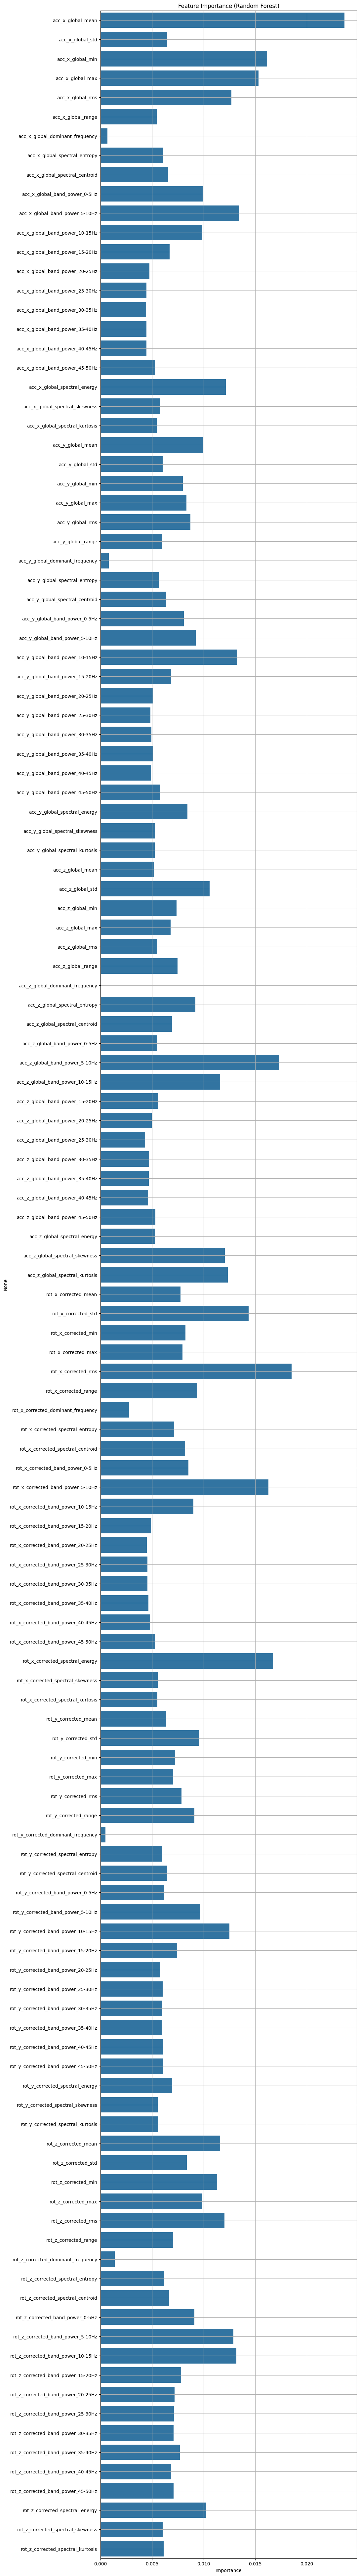

In [ ]:
# BY GOD'S GRACE ALONE
# Graciously visualizing which features are most important

importances = model.feature_importances_
features = X.columns

plt.figure(figsize=(10,100))
sns.barplot(x=importances,y=features)
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.grid(True)
plt.show()